# Draw

In [1]:
import numpy  as np
from copy import copy

import random
import math
import itertools
from more_itertools import pairwise

from random import random, shuffle, uniform, randint
from io import BytesIO

import cairo
import IPython.display
import PIL
import PIL.Image
import PIL.ImageFilter

In [2]:
XMAX = 100
XMIN = -95

YMAX = 185
YMIN = -90

XMID = (XMAX + XMIN) / 2.0
YMID = (YMAX + YMIN) / 2.0

WIDTH = XMAX - XMIN
HEIGHT = YMAX - YMIN

PEN_DELAY = 125

START_X = 0
START_Y = -200

WIDTH, HEIGHT

(195, 275)

In [3]:
def clamp(value, min_value, max_value):
    return min(max(value, min_value), max_value)

In [4]:
def factors_of(x):
    return [
        n for n in range(1, x + 1)
        if x % n == 0
    ]

def common_factors(x, y):
    xf = factors_of(x)
    yf = factors_of(y)
    
    return [
        n for n in xf if n in yf
    ]

In [5]:
class GCODE:
    def __init__(self, name="foobar", feedrate=1000):
        self.start_pos = np.array([START_X, START_Y])
        self.pos = copy(self.start_pos)
        self.f = open(f"{name}.gcode", "wt")
        self.feedrate = feedrate
        
        self.servo = "P0"
        self.pen_up_pos = "S0"
        self.pen_down_pos = "S90"
         
        self.f.write("M17\n")  # Ensure steppers are enabled
        self.f.write("M121\n")  # Disable endstops, just in case
        self.f.write("G90\n")  # Set absolute positioning
        self.f.write("; potatolangelo\n")
        self.pen_up()
        self.move_to_starting_position()
        
    def pen_up(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_up_pos} T{PEN_DELAY}\n")
    
    def pen_down(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_down_pos} T{PEN_DELAY}\n")
        
    def finish_moves(self):
        self.f.write("M400\n")
        
    def move_to(self, x, y, feedrate=None):
        feedrate = feedrate or self.feedrate
        
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def move_to_mid_point(self, feedrate=None):
        self.move_to(XMID, YMID, feedrate=feedrate)
        
    def move_to_starting_position(self, feedrate=None):
        self.move_to(START_X, START_Y, feedrate=feedrate)
        
    def step(self, dx, dy, feedrate=None):
        feedrate = feedrate or self.feedrate
        self.pos[0] += dx
        self.pos[1] += dy
        
        x = self.pos[0]
        y = self.pos[1]
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def square_filled(self, xmin, ymin, xmax, ymax, dy=1, zigzag=True):
#         print(f"square filled centered on {(xmin + xmax) / 2.0:.2f} {(ymin + ymax) / 2.0:.2f}")
        
        self.pen_up()    
        self.move_to((xmin + xmax) / 2.0, (ymin + ymax) / 2.0)
        
        self.square(xmin, ymin, xmax, ymax)
        
        self.pen_up()    
        self.move_to(xmin, ymin)
        self.pen_down()
        
        x = xmin
        y = ymin
        while y < ymax:
            y += dy
            
            # When zigzag is true the pen moves in a saw tooth pattern,
            # otherwise it goes in a square wave form.
            # Zigzag looks good with ballpoint pens, while the square pattern
            # works best on thicker points.
            if not zigzag:
                self.move_to(x, y)
            
            if x == xmin:
                x = xmax
            else:
                x = xmin
                
            self.move_to(x, y)
            
        self.pen_up()
                
    def square(self, xmin, ymin, xmax, ymax):
        self.move_to(xmin, ymin)
        self.pen_down()
        self.move_to(xmax, ymin)
        self.move_to(xmax, ymax)
        self.move_to(xmin, ymax)
        self.move_to(xmin, ymin)
        self.pen_up()
        
    def line(self, x1, y1, x2, y2):
        self.pen_up()
        self.move_to(x1, y1)
        self.pen_down()
        self.move_to(x2, y2)
        self.pen_up()
        
    def draw_boundaries(self):
        self.square(XMIN, YMIN, XMAX, YMAX)
            
    def flush(self):
        self.f.flush()

# The drawing algo

In [6]:
common_factors(WIDTH, HEIGHT)

[1, 5]

In [9]:
basename = "maze_1"
block_size = 5

gcode = GCODE(basename, feedrate=1000)
gcode.move_to_starting_position()

gcode.pen_down()
gcode.draw_boundaries()

for y in range(YMIN, YMAX, block_size):
    for x in range(XMIN, XMAX, block_size):
        x1 = x
        y1 = y
        x2 = x
        y2 = y
        r = randint(0, 3)
        if r == 0:
            x2 = x - block_size
            y2 = y - block_size
        elif r == 1:
            x2 = x - block_size
            y2 = y + block_size
        elif r == 2:
            x2 = x + block_size
            y2 = y + block_size
        elif r == 3:
            x2 = x + block_size
            y2 = y - block_size
            
        gcode.line(
            x1, y1,
            x2, y2,
        )

gcode.pen_up()

gcode.move_to_starting_position()
gcode.flush()

# Preview

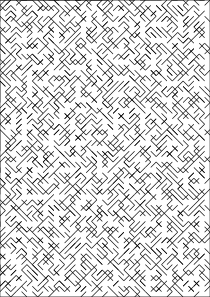

In [10]:
svgio = BytesIO()
filename = f"{basename}.gcode"

last_x = (START_X - XMIN) / (XMAX - XMIN)
last_y = (START_Y - YMIN) / (YMAX - YMIN)

width = 210
height = 297

drawing = False

with cairo.SVGSurface(svgio, width, height) as surface, open(filename) as f:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.0025)
    context.set_source_rgba(0, 0, 0, 1)
    
    for line in f.readlines():
        if "G0" in line:
                
            tokens = line.strip().split(" ")[1:]
            x = (float(tokens[0][1:]) - XMIN) / (XMAX - XMIN)
            y = (float(tokens[1][1:]) - YMIN) / (YMAX - YMIN)

            if writing:  
                context.move_to(last_x, last_y)
                context.line_to(x, y)
                context.stroke()

            last_x = x
            last_y = y
            
        if "M280 P0" in line:
            tokens = line.strip().split(" ")[1:]
            if tokens[1] == "S0":
                writing = False
            elif tokens[1] == "S90":
                writing = True

IPython.display.SVG(data=svgio.getvalue())